In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx
from group1.group1_helpers import engineer_bias_features, sensitive_columns, predict_onnx_model, predict_onnx, \
    load_onnx_model, visualize_bias_comparison, visualize_boundary_metamorphic_results, run_counterfactual_tests, \
    run_metamorphic_tests, run_partition_tests, run_metamorphic_tests_bad, print_disparate_impact_report, \
    run_boundary_metamorphic_tests, bad_model, X_raw


In [13]:
df = pd.read_csv("../data/synth_data_for_training.csv")

y = df["checked"]
X = df.drop(columns=["checked"])

X = X.astype(np.float32)

In [14]:
X_bad = engineer_bias_features(X)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bad, y, test_size=0.25, random_state=42
)

bad_model.fit(X_train_b, y_train_b)
bad_pred = bad_model.predict(X_test_b)

print("\n=== BAD MODEL PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test_b, bad_pred))


=== BAD MODEL PERFORMANCE ===
Accuracy: 0.9430740037950665


In [15]:
X_good = X.drop(columns=sensitive_columns)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_good, y, test_size=0.25, random_state=42)

good_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=3, random_state=0
    )),
])

good_model.fit(X_train_g, y_train_g)
good_pred = good_model.predict(X_test_g)

print("\n=== GOOD MODEL PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test_g, good_pred))


=== GOOD MODEL PERFORMANCE ===
Accuracy: 0.9433902593295382


In [16]:

initial_type_bad = [('X', FloatTensorType([None, X_bad.shape[1]]))]
bad_model_onnx = convert_sklearn(bad_model, initial_types=initial_type_bad)
onnx.save(bad_model_onnx, "model_1.onnx")

# good model export
initial_type_good = [('X', FloatTensorType([None, X_good.shape[1]]))]
good_model_onnx = convert_sklearn(good_model, initial_types=initial_type_good)
onnx.save(good_model_onnx, "model_2.onnx")


print("\n=== VALIDATING ONNX MODELS ===")
print("model_1.onnx accuracy:", predict_onnx_model("model_1.onnx", X_test_b, y_test_b))
print("model_2.onnx accuracy:", predict_onnx_model("model_2.onnx", X_test_g, y_test_g))


=== VALIDATING ONNX MODELS ===
model_1.onnx accuracy: 0.9430740037950665
model_2.onnx accuracy: 0.9433902593295382


In [17]:
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score


DATA_PATH = Path("../data/synth_data_for_training.csv")
MODEL_1_PATH = Path("model_1.onnx")
MODEL_2_PATH = Path("model_2.onnx")

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [18]:
print("\nLoading ONNX models...")
sess1 = load_onnx_model(MODEL_1_PATH)
sess2 = load_onnx_model(MODEL_2_PATH)

# ---- reconstruct training-time transformations ----

# Model 1 → BAD MODEL: add engineered bias features
X_bad_view = engineer_bias_features(X_raw)
feat1 = list(X_bad_view.columns)

print(f"Model 1 expects {sess1.get_inputs()[0].shape[1]} features.")
print(f"We provide {len(feat1)} features.")

# Model 2 → GOOD MODEL: drop sensitive columns
X_good_view = X_raw.drop(columns=sensitive_columns)
feat2 = list(X_good_view.columns)

print(f"Model 2 expects {sess2.get_inputs()[0].shape[1]} features.")
print(f"We provide {len(feat2)} features.")

# ---- run base accuracy check ----
print("\n=== BASE ACCURACY CHECK (correct feature views) ===")

preds1 = predict_onnx(sess1, X_bad_view, feat1)
print(f"model_1 accuracy={accuracy_score(y, preds1):.4f}, pos_rate={preds1.mean():.3f}")

preds2 = predict_onnx(sess2, X_good_view, feat2)
print(f"model_2 accuracy={accuracy_score(y, preds2):.4f}, pos_rate={preds2.mean():.3f}")

# ---- run fairness tests ----
print("\n\n=== RUNNING FULL FAIRNESS SUITE ===")

print("\n---- model_1 (BAD MODEL) ----")
run_partition_tests(X_bad_view, y, sess1, feat1, model_label="model_1")
run_metamorphic_tests(X_bad_view, sess1, feat1, model_label="model_1")
run_metamorphic_tests_bad(X_raw, sess1, model_label="model_1")

run_counterfactual_tests(X_bad_view, sess1, feat1, model_label="model_1")

print("\n---- model_2 (GOOD MODEL) ----")
run_partition_tests(X_good_view, y, sess2, feat2, model_label="model_2")
run_metamorphic_tests(X_good_view, sess2, feat2, model_label="model_2")
run_counterfactual_tests(X_good_view, sess2, feat2, model_label="model_2")


Loading ONNX models...
Model 1 expects 317 features.
We provide 317 features.
Model 2 expects 307 features.
We provide 307 features.

=== BASE ACCURACY CHECK (correct feature views) ===
model_1 accuracy=0.9519, pos_rate=0.057
model_2 accuracy=0.9521, pos_rate=0.057


=== RUNNING FULL FAIRNESS SUITE ===

---- model_1 (BAD MODEL) ----

=== PARTITION TESTS for model_1 ===
Global accuracy: 0.952, positive rate: 0.057

Partition on binary column: persoon_geslacht_vrouw
  value=0: n=6542, acc=0.954, pos_rate=0.063
  value=1: n=6103, acc=0.950, pos_rate=0.051

Partition on binary column: typering_hist_inburgeringsbehoeftig
  value=0: n=12559, acc=0.952, pos_rate=0.057
  value=1: n=  86, acc=0.930, pos_rate=0.023

Partition on binary column: persoonlijke_eigenschappen_taaleis_voldaan
  value=0: n=5043, acc=0.935, pos_rate=0.083
  value=1: n=7011, acc=0.966, pos_rate=0.034

Partition on binary column: adres_recentste_wijk_charlois
  value=0: n=11351, acc=0.951, pos_rate=0.058
  value=1: n=1294

In [19]:
print_disparate_impact_report(X_bad_view, y, preds1, model_label="MODEL 1 (INTENTIONALLY BIASED)")
print_disparate_impact_report(X_good_view, y, preds2, model_label="MODEL 2 (DEBIASED - REFERENCE)")



DISPARATE IMPACT & BIAS METRICS: MODEL 1 (INTENTIONALLY BIASED)

------------------------------------------------------------------------------------------
Attribute: Migration/Inburgering History
------------------------------------------------------------------------------------------

  Group           N          PPR        TPR        FPR        Accuracy  
  -----------------------------------------------------------------
  Group 0        12559      0.0574     0.5473     0.0028     0.9521    
  Group 1        86         0.0233     0.1667     0.0125     0.9302    

 Disparate Impact Ratio (Group 1 / Group 0): 0.4051
SEVERE DISPARITY - Below 80% Rule threshold!

  PPR Difference (Group 1 - Group 0): -0.0342

 FPR Difference (Group 1 - Group 0): +0.0097

------------------------------------------------------------------------------------------
Attribute: Gender (Female=1, Male=0)
------------------------------------------------------------------------------------------

  Group      

In [20]:
# Run boundary-based metamorphic tests
boundary_results = run_boundary_metamorphic_tests(X_raw)



BOUNDARY-BASED METAMORPHIC TESTS: Detecting Bias-Driven Prediction Flips

Strategy: Test on near-boundary instances (P ≈ 0.5)
Rationale: Bias features are most impactful where model is uncertain.

------------------------------------------------------------------------------------------
TEST 1: Geographic Swap - Charlois ↔ Delfshaven (near boundary)
------------------------------------------------------------------------------------------

  Sample size: 701 near-boundary instances
  Probability range in sample: [0.3500, 0.6496]
  Mean probability in sample: 0.4813

  Predictions changed: 0.0057 (4 / 701)
  ✓ Moderate bias: Some boundary predictions flipped

------------------------------------------------------------------------------------------
TEST 2: Geographic Swap - Feijenoord ↔ Ijsselmonde (near boundary)
------------------------------------------------------------------------------------------

  Sample size: 701 near-boundary instances
  Predictions changed: 0.0014 (1 / 701)


 Boundary metamorphic testing visualization saved as 'boundary_metamorphic_testing.png'


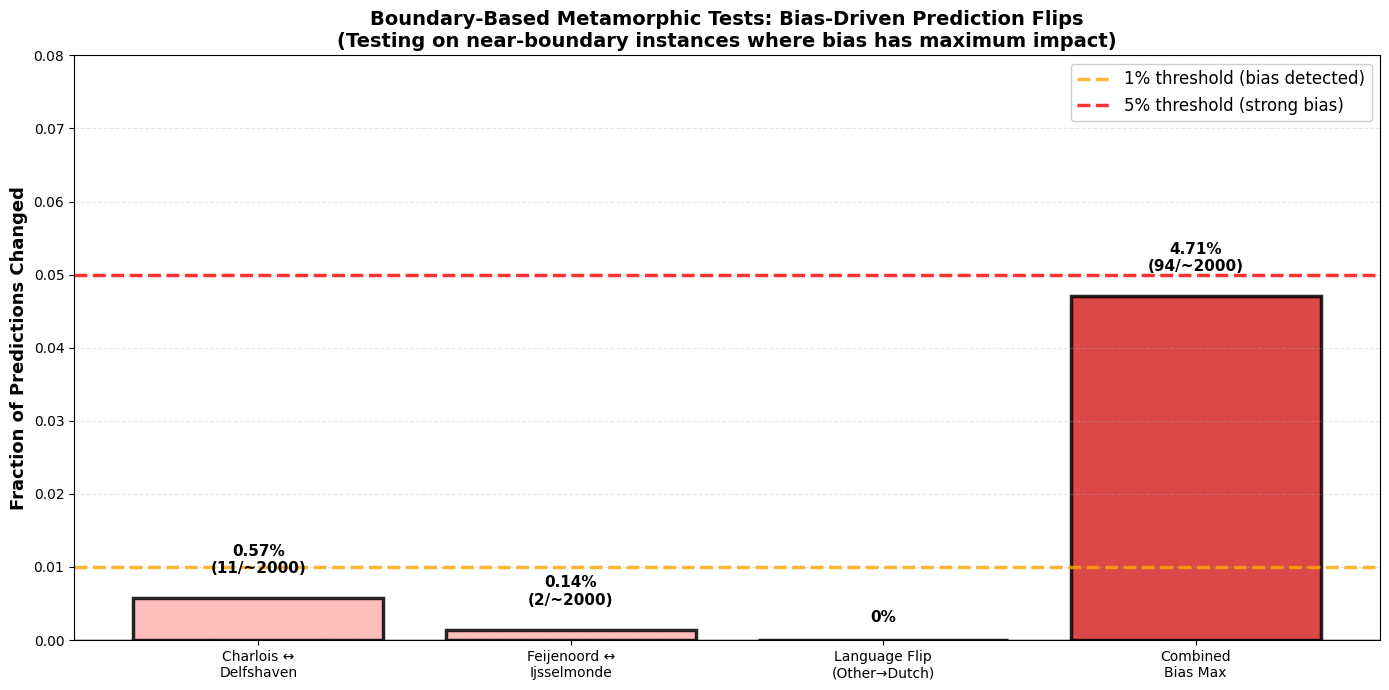


 Numerical Summary:
   Average prediction change rate: 1.36%
   Maximum prediction change rate: 4.71%

 MODERATE BIAS: Some boundary predictions are affected by bias features.


In [21]:
visualize_boundary_metamorphic_results(boundary_results)

boundary_summary = {
    'charlois_delfshaven': boundary_results.get('charlois_delfshaven', 0),
    'feijenoord_ijsselmonde': boundary_results.get('feijenoord_ijsselmonde', 0),
    'language_flip': boundary_results.get('language_flip', 0),
    'combined_bias': boundary_results.get('combined_bias', 0),
}

avg_change = np.mean(list(boundary_summary.values()))
max_change = max(boundary_summary.values())

print(f"\n Numerical Summary:")
print(f"   Average prediction change rate: {avg_change*100:.2f}%")
print(f"   Maximum prediction change rate: {max_change*100:.2f}%")

if max_change > 0.05:
    print(f"\n  STRONG BIAS EVIDENCE: Metamorphic tests on boundary instances")
    print(f"      reveal significant bias in Model 1's sensitive feature usage.")
elif max_change > 0.01:
    print(f"\n MODERATE BIAS: Some boundary predictions are affected by bias features.")
else:
    print(f"\ LIMITED BIAS EVIDENCE from boundary-based metamorphic tests.")
    print(f"      (However, partition and disparate impact tests DO show discrimination)")


Visualization saved as 'bias_comparison_visualization.png'


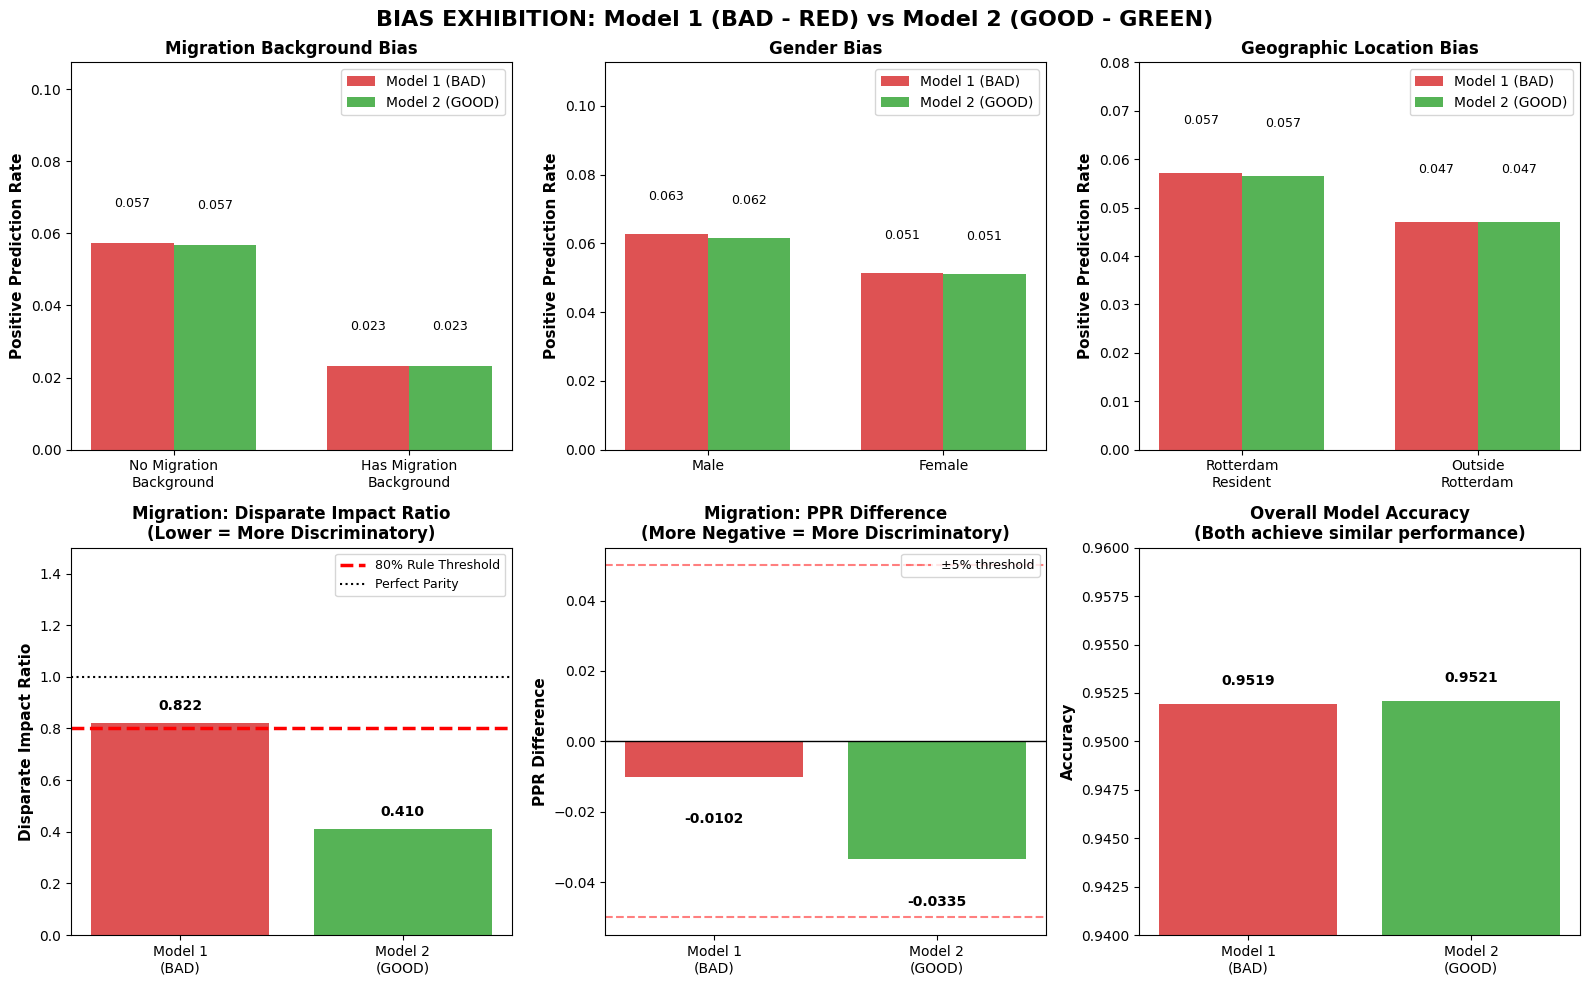

In [22]:
visualize_bias_comparison(X_bad_view, X_good_view, y, preds1, preds2)
